<a href="https://colab.research.google.com/github/alekseyeliseev/plant-pathology-2021/blob/main/Plant_Pathology_2021_(TF)_TPU_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import numpy as np
import pandas as pd
import os, random, cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, StratifiedKFold

import tensorflow as tf
from tensorflow import keras

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
!pip install -qq tensorflow-addons

import tensorflow_addons as tfa

In [ ]:
print('Using tensorflow %s' % tf.__version__)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Using tensorflow 2.4.1
Running on TPU  grpc://10.114.239.106:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.114.239.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.239.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


## Data Loading

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#!unzip -qq 'drive/My Drive/Datasets/plant-pathology-2021-fgvc8.zip' -d '/content/sample_data'

In [ ]:
!cp 'drive/My Drive/Datasets/train.csv' -d '/content/sample_data'

In [ ]:
import pandas as pd
PATH = '/content/sample_data/'
GCS_DS_PATH = 'gs://kds-252b4374f6acf74f9a270d11321c33a94cf2d7d8696d3a48b8f21509/'
train_df = pd.read_csv(PATH + 'train.csv')

##  Label formatting

### V1 Multiclass

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

le.fit(train_df.labels)
train_df['labels'] = le.transform(train_df.labels)

In [ ]:
train = train_df.copy()

In [ ]:
train['path'] = GCS_DS_PATH + 'train_images/' + train['image']

In [ ]:
train.head()

,image,labels,path
0,800113bb65efe69e.jpg,3,gs://kds-252b4374f6acf74f9a270d11321c33a94cf2d...
1,8002cb321f8bfcdf.jpg,11,gs://kds-252b4374f6acf74f9a270d11321c33a94cf2d...
2,80070f7fb5e2ccaa.jpg,9,gs://kds-252b4374f6acf74f9a270d11321c33a94cf2d...
3,80077517781fb94f.jpg,9,gs://kds-252b4374f6acf74f9a270d11321c33a94cf2d...
4,800cbf0ff87721f8.jpg,0,gs://kds-252b4374f6acf74f9a270d11321c33a94cf2d...


## Helper Function

In [ ]:
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

## Global config

In [ ]:
CFG = {
    'n_classes':12,
    'fold_num': 5,
    'seed': 42,
    'img_size': 512,
    'epochs': 20,
    'train_bs': 8 * strategy.num_replicas_in_sync,
    'valid_bs': 32 * strategy.num_replicas_in_sync,
    'verbose_step': 1,
    
    'optimizer':'Adam',
    'lr': 1e-4,
 
    'used_folds':[0]
}

## Classifier

In [ ]:
!pip install -q efficientnet

In [ ]:
def create_model():  
  import efficientnet.tfkeras as efn 
  from keras.models import Model
  from keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D

  shape = (CFG['img_size'], CFG['img_size'], 3)

  efficientnet = efn.EfficientNetB7(weights='noisy-student', include_top=False, 
                                    input_shape=shape)
  x = efficientnet.output
  x = GlobalAveragePooling2D()(x)
  x = tf.keras.layers.Dense(512) (x)
  x = tf.keras.layers.LeakyReLU(alpha=0.2) (x)
  x = tf.keras.layers.Dropout(0.3) (x)
  x = tf.keras.layers.Dense(256) (x)
  x = tf.keras.layers.LeakyReLU(alpha=0.2) (x)
  x = tf.keras.layers.GaussianDropout(0.4) (x)
  outputs = Dense(CFG['n_classes'], activation='softmax')(x)
        
  model = Model(efficientnet.input, outputs)

  return model

In [ ]:
def compile_model(model, lr):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    
    loss = tf.keras.losses.CategoricalCrossentropy()
        
    metrics = [
       tfa.metrics.F1Score(num_classes=CFG['n_classes'], average='macro', name='f1_score'),
       tf.keras.metrics.CategoricalAccuracy(name='accuracy')
    ]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model

## Transfroms

In [ ]:
 def train_aug(image_path, label):
  image = tf.io.read_file(image_path)
  
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32) / 255.0

  #image = tf.image.random_crop(image, size=[CFG['img_size'], CFG['img_size'], 3])
  #image = tf.image.random_brightness(image, max_delta=0.5)
  #image = tf.clip_by_value(image, 0, 1)

  p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  p_rotate = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  p_pixel_2 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
  p_crop = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
            
  # Flips
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_flip_up_down(image)
  if p_spatial > .75:
    image = tf.image.transpose(image)
        
  # Rotates
  if p_rotate > .75:
    image = tf.image.rot90(image, k=3) 
  elif p_rotate > .5:
    image = tf.image.rot90(image, k=2) 
  elif p_rotate > .25:
    image = tf.image.rot90(image, k=1) 
        
    
  if p_pixel_1 >= .4:
    image = tf.image.random_saturation(image, lower=.7, upper=1.3)
  if p_pixel_2 >= .4:
    image = tf.image.random_contrast(image, lower=.8, upper=1.2)
  if p_pixel_3 >= .4:
    image = tf.image.random_brightness(image, max_delta=.1)
        
    
  if p_crop > .7:
    if p_crop > .9:
      image = tf.image.central_crop(image, central_fraction=.7)
    elif p_crop > .8:
      image = tf.image.central_crop(image, central_fraction=.8)
    else:
      image = tf.image.central_crop(image, central_fraction=.9)
  elif p_crop > .4:
    crop_size = tf.random.uniform([], int(CFG['img_size']*.8), CFG['img_size'], dtype=tf.int32)
    image = tf.image.random_crop(image, size=[crop_size, crop_size, 3])
    
  image = tf.image.resize(image, [CFG['img_size'], CFG['img_size']])
    
  #imgage = tf.reshape(image, [CFG['img_size'], CFG['img_size'], 3])   
  label = tf.one_hot(tf.cast(label, tf.int32), CFG['n_classes'])
  
  return image, label

In [ ]:
def valid_aug(image_path, label):
  image = tf.io.read_file(image_path)
  
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.cast(image, tf.float32) / 255.0

  image = tf.image.central_crop(image, central_fraction=.7)
  image = tf.image.resize(image, [CFG['img_size'], CFG['img_size']])
  
  #imgage = tf.reshape(image, [CFG['img_size'], CFG['img_size'], 3])
  label = tf.one_hot(tf.cast(label, tf.int32), CFG['n_classes'])

  return image, label

## Dataloader

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def prepare_dataset(train_df, valid_df):
  
  train_ds = tf.data.Dataset.from_tensor_slices((train_df.path.values, train_df.labels.values))
  valid_ds = tf.data.Dataset.from_tensor_slices((valid_df.path.values, valid_df.labels.values))

  train_ds_aug = train_ds.map(train_aug, num_parallel_calls=AUTOTUNE).batch(CFG['train_bs']).prefetch(AUTOTUNE)
  valid_ds_aug= valid_ds.map(valid_aug, num_parallel_calls=AUTOTUNE).batch(CFG['valid_bs'])

  return train_ds_aug, valid_ds_aug

##Modeling

In [ ]:
lr_reduce=ReduceLROnPlateau(monitor='val_accuracy',
                            factor=.5,
                            patience=3,
                            mode='max',
                            min_lr=.000001,
                            verbose=1)

es_monitor=EarlyStopping(monitor='val_accuracy',
                         patience=6,
                         mode='max',
                         verbose=1,
                         restore_best_weights=True)

mdl_check = ModelCheckpoint(filepath='./best_model.h5',
                            monitor='val_accuracy', 
                            verbose=0, 
                            save_best_only=True, 
                            save_weights_only=True, 
                            mode='max')


In [ ]:
loss = []
acc = []

seed_everything(CFG['seed'])

folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(train.image, train.labels)
for ix, (train_idx, val_idx) in enumerate(folds):
  
  #debug
  if ix not in CFG['used_folds']:
    break

  print(f'Fold {ix+1}')

  if tpu is not None: 
    tf.tpu.experimental.initialize_tpu_system(tpu)

  train_ = train.iloc[train_idx]
  valid_ = train.iloc[val_idx]
        
  train_ds, valid_ds = prepare_dataset(train_,valid_)

  with strategy.scope():
  
    model = create_model()
    model = compile_model(model, lr=CFG['lr'])
    
  
    history = model.fit(train_ds,
                     epochs = CFG['epochs'],
                     verbose = 1,
                     callbacks = [mdl_check,
                                  lr_reduce,
                                  es_monitor
                                  ],
                     validation_data = valid_ds)
  
  print('\n\n')

Fold 1


INFO:tensorflow:Initializing the TPU system: grpc://10.114.239.106:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.114.239.106:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/20
233/233 [==============================] - 691s 2s/step - loss: 1.9632 - f1_score: 0.1282 - accuracy: 0.3373 - val_loss: 0.6994 - val_f1_score: 0.3989 - val_accuracy: 0.7891
Epoch 2/20
233/233 [==============================] - 456s 2s/step - loss: 1.0364 - f1_score: 0.3334 - accuracy: 0.6746 - val_loss: 0.4675 - val_f1_score: 0.4319 - val_accuracy: 0.8535
Epoch 3/20
233/233 [==============================] - 461s 2s/step - loss: 0.8729 - f1_score: 0.3653 - accuracy: 0.7221 - val_loss: 0.4256 - val_f1_score: 0.4392 - val_accuracy: 0.8645
Epoch 4/20
233/233 [==============================] - 463s 2s/step - loss: 0.7763 - f1_score: 0.3887 - accuracy: 0.7512 - val_loss: 0.3929 - val_f1_score: 0.4480 - val_accuracy: 0.8771
Epoch 5/20
233/233 [==============================] - 469s 2s/step - loss: 0.7203 - f1_score: 0.4042 - accuracy: 0.7660 - val_loss: 0.3801 - val_f1_score: 0.4740 - val_accuracy: 0.8758
Epoch 6/20
233/233 [==============================] - 453s 2s/step - loss: 

In [ ]:
from datetime import datetime

now = datetime.now().strftime("%Y-%m-%d-%H-%M")
filename = 'model_{}.h5'.format(now)
os.system("cp ./best_model.h5 'drive/My Drive/Plant Pathology Weights/temp/{0}'".format(filename))

0

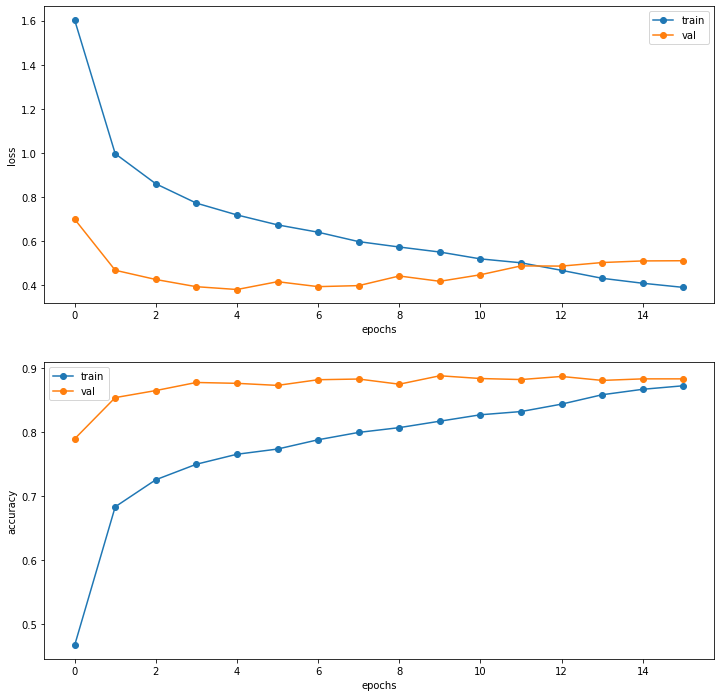

In [ ]:
h = history.history

offset = 0
epochs = range(offset, len(h['loss']))

plt.figure(1, figsize=(12, 12))

plt.subplot(211)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h['loss'][offset:], '-o',label='train')
plt.plot(epochs, h['val_loss'][offset:], '-o', label='val')
plt.legend()

plt.subplot(212)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h[f'accuracy'],'-o', label='train')
plt.plot(h[f'val_accuracy'], '-o', label='val')
plt.legend()

plt.show()